In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image


In [18]:
image_height = 224
image_width = 224
num_channels = 3
batch_size = 32
num_classes = 2

In [19]:
data_path=os.path.join("dataset")
image_classes = os.listdir(data_path)
print(image_classes)

['bird', 'drone']


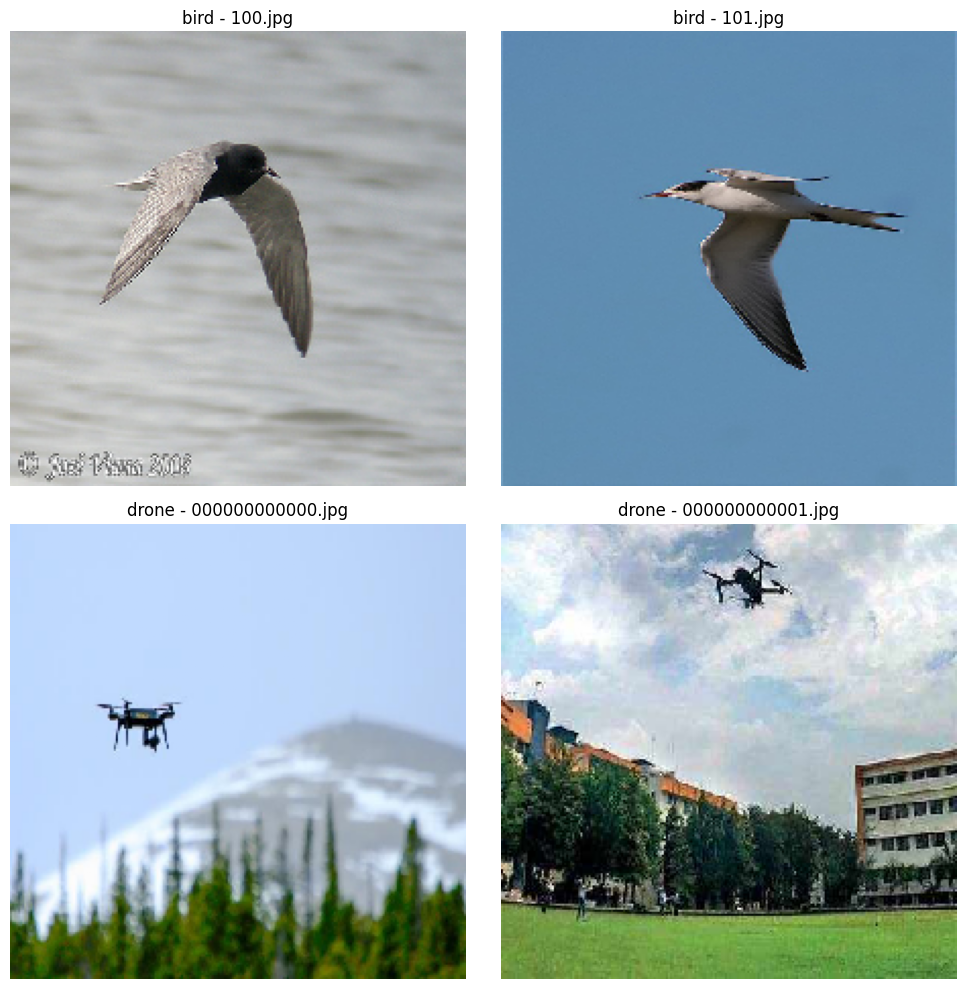

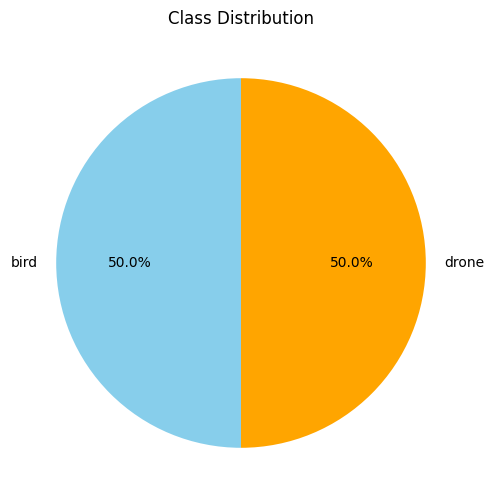

In [20]:
# Display 2 images from both classes
plt.figure(figsize=(10, 10))

for i, category in enumerate(image_classes):
    image_path = os.path.join(data_path, category)
    images_in_folder = os.listdir(image_path)[:2]  # Get first 2 images from each class
    
    for j, image_name in enumerate(images_in_folder):
        img_path = os.path.join(image_path, image_name)
        img = image.load_img(img_path, target_size=(image_height, image_width))
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(2, 2, i * 2 + j + 1)
        plt.imshow(img_array)
        plt.title(f"{category} - {image_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Show a pie chart of class distribution
class_counts = [len(os.listdir(os.path.join(data_path, category))) for category in image_classes]

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=image_classes, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.show()

In [21]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # Split for training and validation
)

In [22]:
train_data = train_datagen.flow_from_directory(
    data_path,  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

Found 2249 images belonging to 2 classes.


In [23]:
val_data = train_datagen.flow_from_directory(
    data_path,  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 963 images belonging to 2 classes.


In [24]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

In [25]:
base_model.trainable = False

In [26]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [27]:
model.compile(
    optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [29]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)

c:\Users\ranz1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8083 - loss: 0.3938 - val_accuracy: 0.9024 - val_loss: 0.2448 - learning_rate: 0.0010
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9558 - loss: 0.1251 - val_accuracy: 0.9055 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9638 - loss: 0.1055 - val_accuracy: 0.8868 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9578 - loss: 0.1062 - val_accuracy: 0.8868 - val_loss: 0.2542 - learning_rate: 0.0010
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9702 - loss: 0.0785 - val_accuracy: 0.9097 - val_loss: 0.2165 - learning_rate: 0.0010
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9598 - loss: 0.1010 - val_accuracy: 0.9013 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9707 - loss: 0.0755 - val_acc

In [30]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9246 - loss: 0.1631
Validation Loss: 0.17134220898151398
Validation Accuracy: 0.9252336621284485


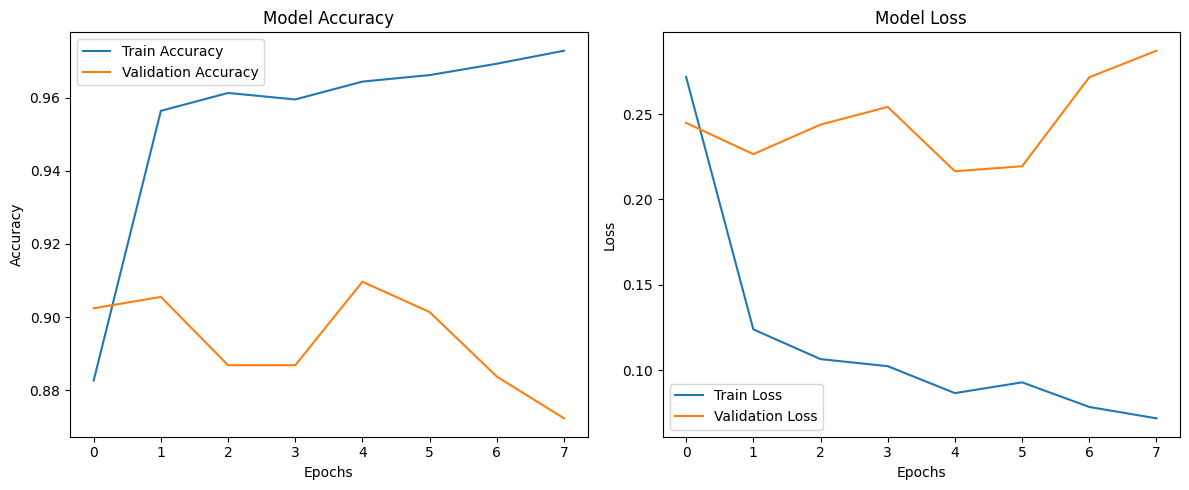

In [31]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [32]:
# Fine-Tune the Model (Unfreeze Base Model)
base_model.trainable = True

# Compile the model again after unfreezing the base model
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [33]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9554 - loss: 0.1252 - val_accuracy: 0.9283 - val_loss: 0.2420 - learning_rate: 1.0000e-04
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.9812 - loss: 0.0573 - val_accuracy: 0.9564 - val_loss: 0.1389 - learning_rate: 1.0000e-04
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9843 - loss: 0.0504 - val_accuracy: 0.8037 - val_loss: 0.9231 - learning_rate: 1.0000e-04
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9932 - loss: 0.0255 - val_accuracy: 0.8224 - val_loss: 0.7202 - learning_rate: 1.0000e-04
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9893 - loss: 0.0309 - val_accuracy: 0.9481 - val_loss: 0.1656 - learning_rate: 1.0000e-04


In [34]:
val_loss_fine, val_accuracy_fine = model.evaluate(val_data)
print(f"Validation Loss (Fine-Tuned): {val_loss_fine}")
print(f"Validation Accuracy (Fine-Tuned): {val_accuracy_fine}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9564 - loss: 0.0988
Validation Loss (Fine-Tuned): 0.14763297140598297
Validation Accuracy (Fine-Tuned): 0.9418483972549438


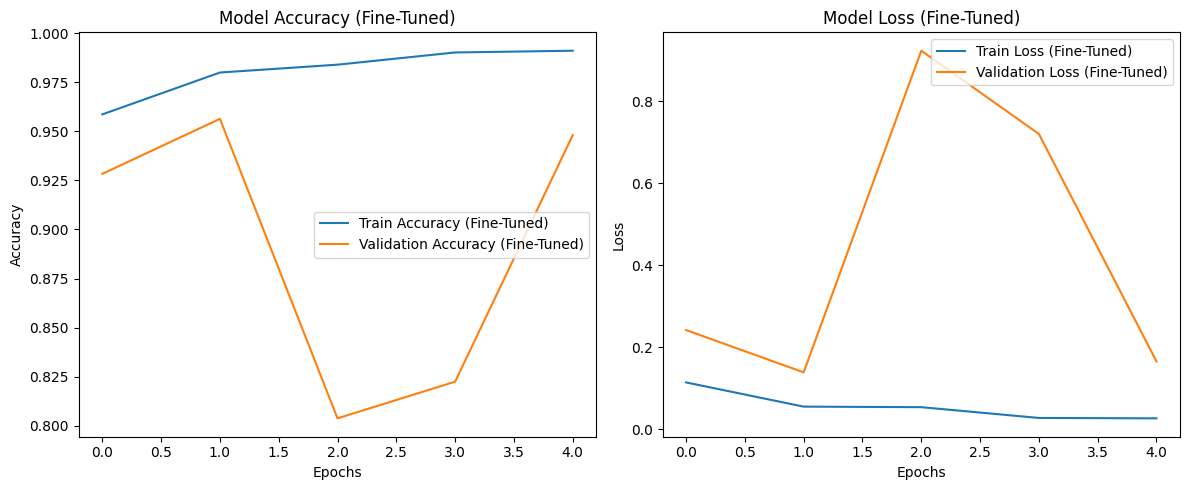

In [35]:
def plot_fine_tuning_history(history_fine):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot 
    plt.subplot(1, 2, 1)
    plt.plot(history_fine.history['accuracy'], label='Train Accuracy (Fine-Tuned)')
    plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Fine-Tuned)')
    plt.title('Model Accuracy (Fine-Tuned)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history_fine.history['loss'], label='Train Loss (Fine-Tuned)')
    plt.plot(history_fine.history['val_loss'], label='Validation Loss (Fine-Tuned)')
    plt.title('Model Loss (Fine-Tuned)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_fine_tuning_history(history_fine)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


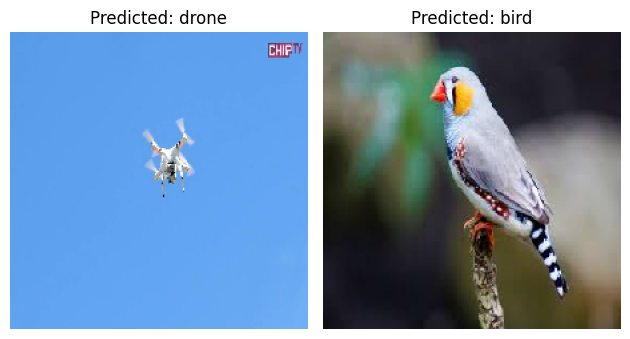

Confidence: 0.97 Confidence: 0.51


In [58]:
# Load and preprocess a test image
test_image_path = r"C:\Users\ranz1\Desktop\New folder\000000000080.jpg"  # Use raw string
test_img = image.load_img(test_image_path, target_size=(image_height, image_width))
test_img_array = image.img_to_array(test_img) / 255.0  # Normalize the image
test_img_array = tf.expand_dims(test_img_array, axis=0)  # Add batch dimension

# Predict using the model
predictions = model.predict(test_img_array)
predicted_class_index = tf.argmax(predictions[0]).numpy()
predicted_class = image_classes[predicted_class_index]

test_image_path2 = r"C:\Users\ranz1\Desktop\bird.jpg"  # Use raw string
test_img2 = image.load_img(test_image_path2, target_size=(image_height, image_width))
test_img_array2 = image.img_to_array(test_img2) / 255.0  # Normalize the image
test_img_array2 = tf.expand_dims(test_img_array2, axis=0)  # Add batch dimension

# Predict using the model
predictions2 = model.predict(test_img_array2)
predicted_class_index2 = tf.argmax(predictions2[0]).numpy()
predicted_class2 = image_classes[predicted_class_index2]
# Add confidence scores to the titles
plt.subplot(1, 2, 1)
plt.title(f"Predicted: {predicted_class}")

plt.subplot(1, 2, 2)
plt.title(f"Predicted: {predicted_class2}")
plt.axis('off')

# First image
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')

# Second image
plt.subplot(1, 2, 2)
plt.imshow(test_img2)
plt.title(f"Predicted: {predicted_class2}")
plt.axis('off')

plt.tight_layout()
plt.show()
print(f"Confidence: {predictions[0][predicted_class_index]:.2f} Confidence: {predictions2[0][predicted_class_index2]:.2f}") 


In [36]:
model.save('BirdVsDrone_model.h5')